In [69]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:5%]','test[:2%]','validation[:2%]'],
                        data_dir = '/content/gdrive/My Drive/exam/',
                        download=False,
                        shuffle_files=True)

In [72]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [73]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

In [74]:
print(f'length of training dataset: {len(train_dataset)}, length of validation dataset: {len(validation_dataset)} and length of test dataset: {len(test_dataset)}')

length of training dataset: 410, length of validation dataset: 21 and length of test dataset: 21


In [75]:
for images, labels in train_dataset.take(1):
    batch_size = images.shape[0]
    print("Batch size:", batch_size)
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Batch size: 32
Images shape: (32, 96, 96, 3)
Labels shape: (32, 2)


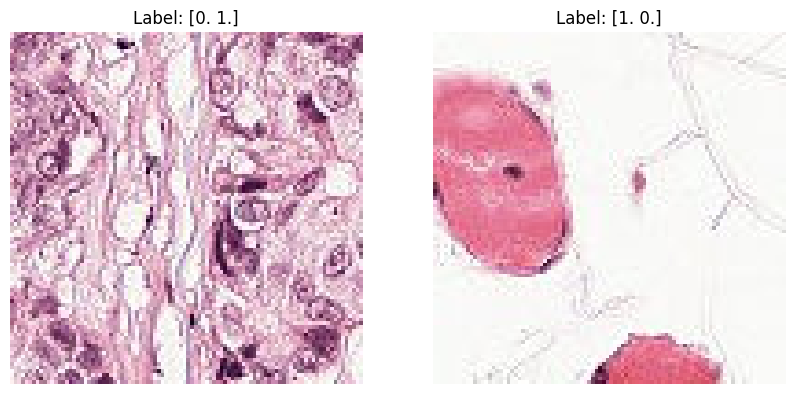

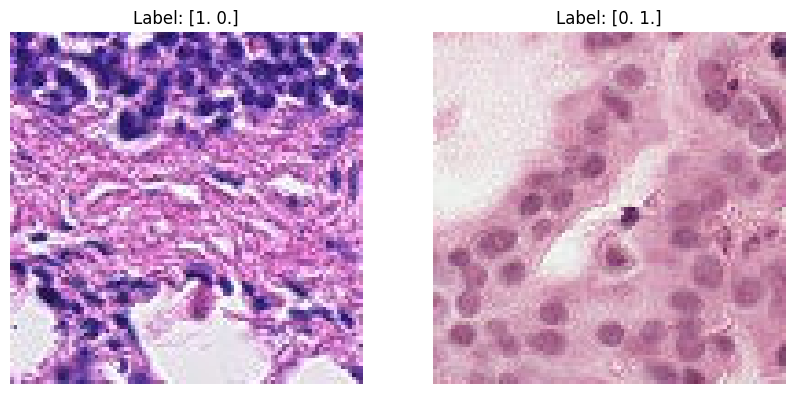

In [76]:
for images, labels in train_dataset.take(2):
    for i in range(1):
        image_1 = images[i].numpy()
        label_1 = labels[i].numpy()
        image_2 = images[i+1].numpy()
        label_2 = labels[i+1].numpy()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(image_1)
        axes[0].set_title(f'Label: {label_1}')
        axes[0].axis('off')

        axes[1].imshow(image_2)
        axes[1].set_title(f'Label: {label_2}')
        axes[1].axis('off')

        plt.show()

In [77]:
def convert_sample_for_autoencoder(sample):
    image = sample['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image

train_dataset_autoencoder = ds1.map(convert_sample_for_autoencoder).batch(32)
validation_dataset_autoencoder = ds3.map(convert_sample_for_autoencoder).batch(32)

In [146]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
], name='encoder')

decoder = tf.keras.models.Sequential([

    tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(12, 12, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D(size=(2, 2)),

    tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D(size=(2, 2)),

    tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D(size=(2, 2)),

    tf.keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
], name='decoder')

In [147]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_51 (Ba  (None, 96, 96, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_52 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                           

In [152]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate=0.0001)

autoencoder.compile(loss='mse', optimizer=optimizer)

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 12, 12, 3)         21519     
                                                                 
 decoder (Sequential)        (None, 96, 96, 3)         97603     
                                                                 
Total params: 119122 (465.32 KB)
Trainable params: 118476 (462.80 KB)
Non-trainable params: 646 (2.52 KB)
_________________________________________________________________


In [ ]:
history = autoencoder.fit(
    train_dataset_autoencoder,
    epochs=1,
    validation_data=validation_dataset_autoencoder
)

In [82]:
compressed_data = encoder.predict(train_dataset)
print(compressed_data.shape)

410/410 [==============================] - 8s 18ms/step
(13107, 12, 12, 3)


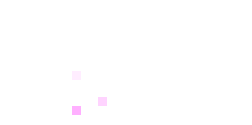

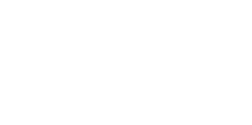

In [155]:
for i in range(2):
    compressed_image_1 = compressed_data[i]
    compressed_image_2 = compressed_data[i+1]

    fig, axes = plt.subplots(1, 2, figsize=(3, 3))

    axes[0].imshow(compressed_image_1)
    axes[0].axis('off')

    axes[1].imshow(compressed_image_2)
    axes[1].axis('off')

    plt.show()